In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sigpy.mri
import sigpy.plot

sitk_t1=sitk.ReadImage('../files/t1.nii.gz')
t1=sitk.GetArrayFromImage(sitk_t1)
print(t1.shape)

/home/oscar/Programs/miniconda3/envs/imrcenv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
No module named 'cupyx.cudnn'
  warnings.warn(


(90, 256, 256)


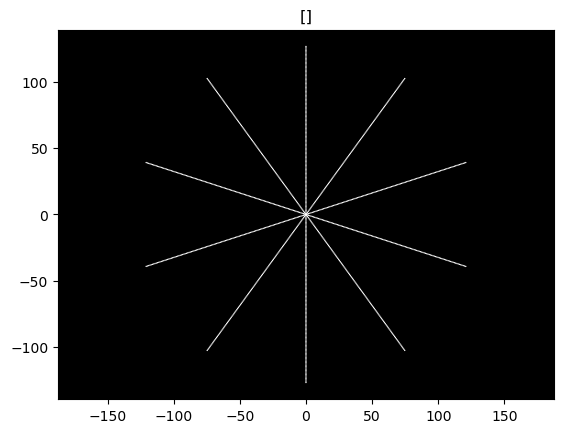

(10, 128, 2)

In [2]:
coord = sigpy.mri.radial([10,128,2],[256,256],golden=False)
sigpy.plot.ScatterPlot(coord)
coord.shape

The function `sigpy.mri.radial` outputs a set of spokes containing sampling points in a radial trajectory. Each spoke extends from the origin, but not across it. To set up the reconstruction with CT techniques we require that these spokes extend across the origin in k-space. The samples of k-space in each spoke correspond to a single projection in the sinogram at the angle at which said spoke is oriented in k-space. To convert the radial trajectory output by `sigpy` to a radial trajectrory with spokes that co across the origin, we do:

In [3]:
coord_across = []
ns2 = int(len(coord)/2) # Half the number of spokes in coord
for sp1, sp2 in zip(coord[:ns2], coord[ns2:]):
    coord_across.append(np.vstack([sp2[::-1], sp1]))
coord_across = np.array(coord_across)
coord_across.shape

(5, 256, 2)

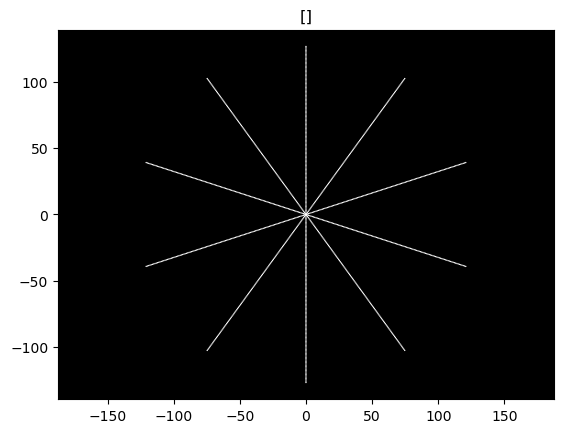

In [4]:
sigpy.plot.ScatterPlot(coord_across)

This has benn added as a function `get_radial_across` in the module `utils` of this project, for easy use

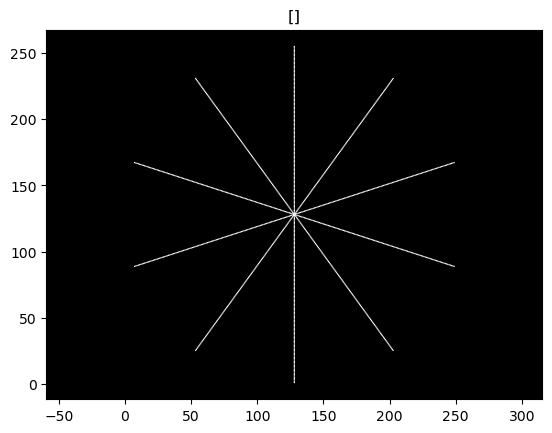

In [5]:
from utils import *
coord_across_tr = translate_spokes_to_img_coord(coord_across)

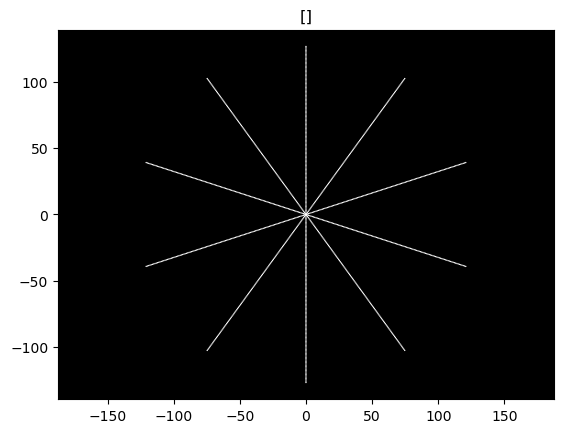

In [6]:
racc = get_radial_across(coord)
sigpy.plot.ScatterPlot(racc)

(180, 256, 2)


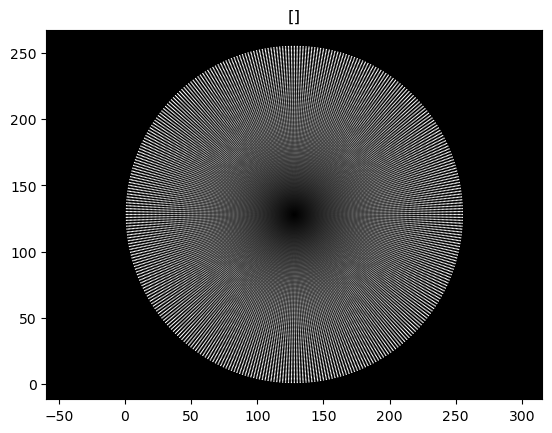

Acceleration factor: 1.4219401041666666


In [90]:
original = t1[45]
ksp = sigpy.fft(original)
N_spokes = 360
N_samples = 128
coord = sigpy.mri.radial([N_spokes, N_samples, 2], [256, 256], golden=False)
coord_across = []
ns2 = int(len(coord)/2) # Half the number of spokes in coord
for sp1, sp2 in zip(coord[:ns2], coord[ns2:]):
    coord_across.append(np.vstack([sp2[::-1], sp1]))
coord_across = np.array(coord_across)
print(coord_across.shape)
coord = coord_across
ramp_filter = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
coord = translate_spokes_to_img_coord(coord, (256, 256))
sigpy.plot.ScatterPlot(coord, ramp_filter)
print(f"Acceleration factor: {65523/(N_spokes*N_samples)}")

Since the resulting spokes across the origin are evenly spaced (make sure `golden = False`), the angles at which they are can be easily obtained by simply doing

In [22]:
angles = np.linspace(0,180,int(N_spokes/2))
angles.shape

(180,)

We assume the CT acquisition goes only from 0º to 180º and we only have one acquisition to reconstruct. We sample the k-space without the filter, as this is going to be implemented via FBP. We only need the sinogram, which is obtained from the inverse Fourier transform of each spoke.

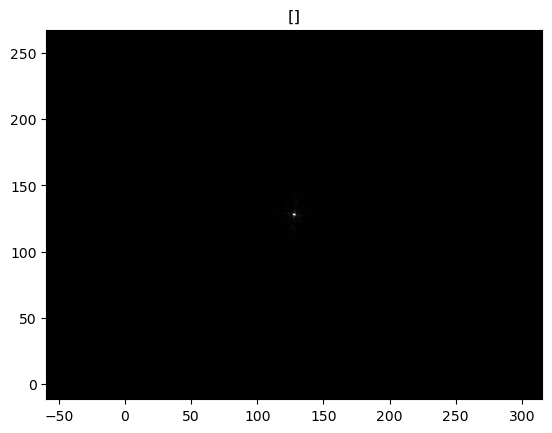

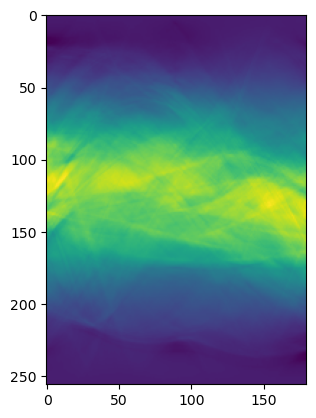

In [113]:
ksp_sampled = sigpy.interpolate(ksp, coord)
sino = np.array([sigpy.ifft(spoke, oshape=(256,), center=True) for spoke in ksp_sampled])
sigpy.plot.ScatterPlot(coord, ksp_sampled)
plt.imshow(np.flip(np.real(sino.T)))

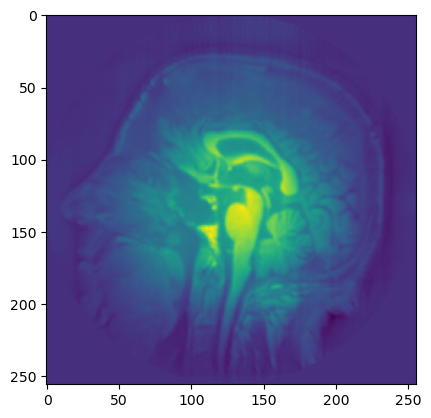

In [114]:
from skimage.transform import radon,iradon
reco_fbp = iradon(np.real(sino.T), theta=angles, filter_name='hann')
plt.imshow(np.flip(reco_fbp))

/home/oscar/Programs/miniconda3/envs/imrcenv/lib/python3.10/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


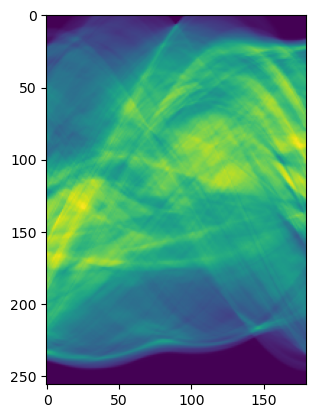

In [54]:
sino_ref = radon(original, angles)
plt.imshow(sino_ref)

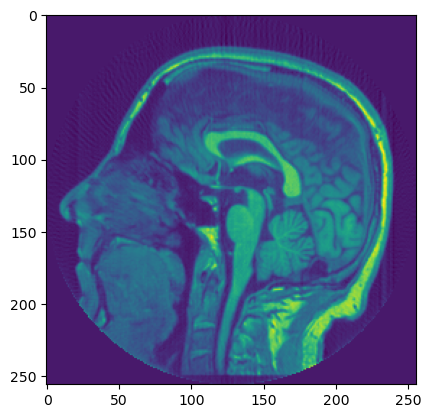

In [72]:
plt.imshow(iradon(sino_ref, angles, filter_name='ramp'))